## Sentiment Analysis

#### Data Collection - Kaggle

In [2]:
# importing the libraries
import pandas as pd 
import numpy as np
import sqlite3

In [3]:
# reading the data and confirming it is more than 25K 
data = pd.read_csv(r"Data\IMDB Dataset.csv")
print("Data Shape : ", data.shape)
display(data.head(5))

Data Shape :  (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
print("Data before removing duplicates : ", data.shape)
data.drop_duplicates(inplace=True)
print("Data after removing duplicates : ", data.shape)

Data before removing duplicates :  (50000, 2)
Data after removing duplicates :  (49582, 2)


#### Database Setup

In [5]:
# Connect to SQLite DB (or create one)
conn = sqlite3.connect('imdb_reviews.db')
cursor = conn.cursor()

# Create table
cursor.execute('''CREATE TABLE IF NOT EXISTS imdb_reviews
                  (id INTEGER PRIMARY KEY AUTOINCREMENT,
                   review_text TEXT,
                   sentiment TEXT)''')

In [6]:
for index, row in data.iterrows():
    cursor.execute("INSERT INTO imdb_reviews (review_text, sentiment) VALUES (?, ?)",
                   (row['review'], row['sentiment']))

conn.commit()
conn.close()

In [7]:
# Connect to the SQLite database (change the path to where your DB is stored)
conn = sqlite3.connect('imdb_reviews.db')

# SQL query to select all data from the table
query = "SELECT * FROM imdb_reviews"

# Load the data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Display the first few rows of the DataFrame
display(df.head())

,id,review_text,sentiment
0,1,One of the other reviewers has mentioned that ...,positive
1,2,A wonderful little production. <br /><br />The...,positive
2,3,I thought this was a wonderful way to spend ti...,positive
3,4,Basically there's a family where a little boy ...,negative
4,5,"Petter Mattei's ""Love in the Time of Money"" is...",positive


#### Data Cleaning

In [8]:
# dropping the duplicate values 
print("Before dropping the duplicates : ", data.shape)
df.drop_duplicates(inplace=True)
print("After dropping the duplicates : ", data.shape)

Before dropping the duplicates :  (49582, 2)
After dropping the duplicates :  (49582, 2)


In [9]:
import re 
# checking how many rows have html tags 
def contains_html(text):
    html_pattern = re.compile(r'<.*?>')  # Regex pattern for HTML tags
    return bool(html_pattern.search(text))  # Return True if HTML tags are found

html_rows = df['review_text'].apply(contains_html)
count_html_rows = html_rows.sum()

print(f"Number of rows containing HTML tags: {count_html_rows}")

Number of rows containing HTML tags: 28968


In [10]:
# removing the html tags from the text
import string

def remove_html(text):
    clean_text = re.sub(r'<.*?>', '', text)  # Remove anything that looks like an HTML tag
    return clean_text

df['cleaned_review_text'] = df['review_text'].apply(remove_html)

# lowering the text and removing the punctuations 
def lower_and_punctuation(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

df['cleaned_review_text'] = df['cleaned_review_text'].apply(lower_and_punctuation)

# Display the first few rows with cleaned text
display(df[['review_text', 'cleaned_review_text']].head())

,review_text,cleaned_review_text
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love in the time of money is a ...


In [11]:
# updating the cleaned text in the database as well 
conn = sqlite3.connect('imdb_reviews.db')
cursor = conn.cursor()

for index, row in df.iterrows():
    cursor.execute("UPDATE imdb_reviews SET review_text = ? WHERE id = ?", (row['cleaned_review_text'], row['id']))

conn.commit()
conn.close()

In [12]:
# deleting the variables 
del data, df

In [13]:
# importing the cleaned data
# Connect to the SQLite database (change the path to where your DB is stored)
conn = sqlite3.connect('imdb_reviews.db')

# SQL query to select all data from the table
query = "SELECT * FROM imdb_reviews"

# Load the data into a pandas DataFrame
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Display the first few rows of the DataFrame
display(df.head())

,id,review_text,sentiment
0,1,one of the other reviewers has mentioned that ...,positive
1,2,a wonderful little production the filming tech...,positive
2,3,i thought this was a wonderful way to spend ti...,positive
3,4,basically theres a family where a little boy j...,negative
4,5,petter matteis love in the time of money is a ...,positive


#### Exploratory Data Analysis 

In [14]:
import matplotlib.pyplot as plt 
import seaborn as sns

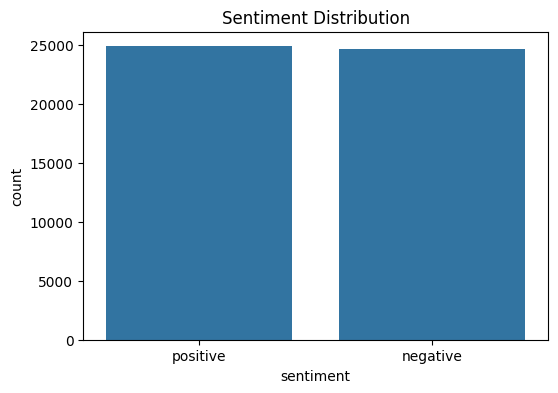

In [15]:
# sentiment distribution plot 
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()

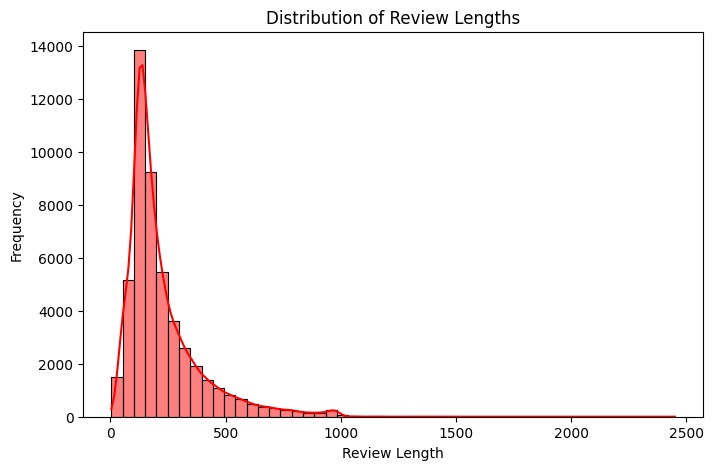

In [17]:
# distribution of review lengths
df['review_length'] = df['review_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 5))
sns.histplot(df['review_length'], bins=50, kde=True, color='red')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

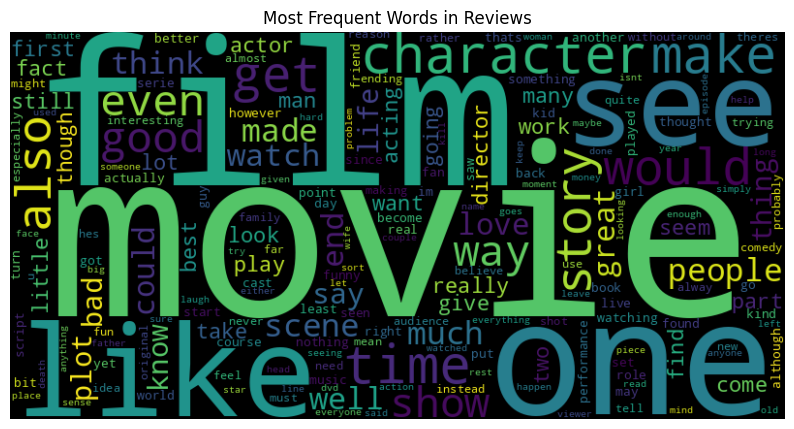

In [18]:
# word cloud 
from wordcloud import WordCloud
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
text = " ".join(review for review in df['review_text'])
wordcloud = WordCloud(width=800, height=400, stopwords=stop_words).generate(text)

# Plot the Word Cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Reviews')
plt.show()

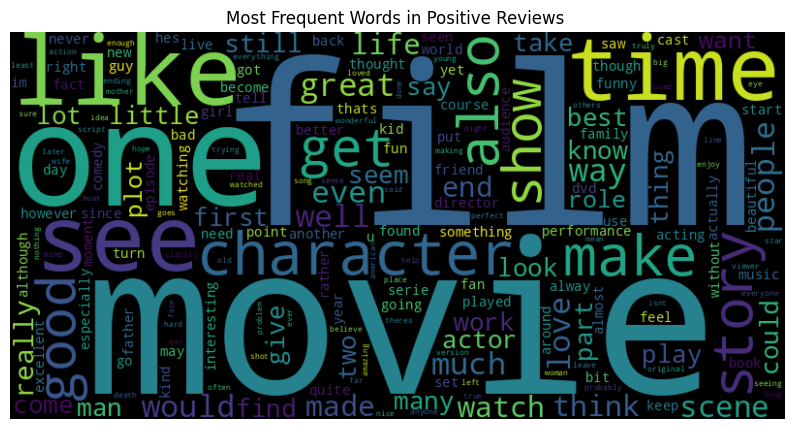

In [19]:
from wordcloud import WordCloud
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
text = " ".join(review for review in df[df['sentiment'] == 'positive']['review_text'])
wordcloud = WordCloud(width=800, height=400, stopwords=stop_words).generate(text)

# Plot the Word Cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Positive Reviews ')
plt.show()

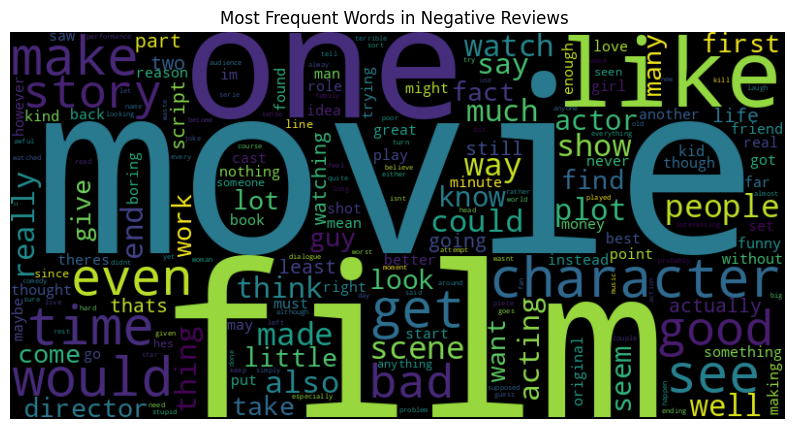

In [20]:
from wordcloud import WordCloud
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
text = " ".join(review for review in df[df['sentiment'] == 'negative']['review_text'])
wordcloud = WordCloud(width=800, height=400, stopwords=stop_words).generate(text)

# Plot the Word Cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Negative Reviews ')
plt.show()

#### Model Training - Baseline (Naive Bayes)

In [21]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def clean_text(text):
    words = word_tokenize(text)  # Tokenize
    filtered_words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(filtered_words)

# Apply the cleaning function to the 'review_text' column
df['cleaned_review_text'] = df['review_text'].apply(clean_text)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features for performance
X = vectorizer.fit_transform(df['cleaned_review_text'])

# Target variable (sentiment)
y = df['sentiment'].map({'positive': 1, 'negative': 0})  # Convert sentiments to binary values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = nb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Output results
print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.8504
Confusion Matrix:
[[4164  775]
 [ 709 4269]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      4939
           1       0.85      0.86      0.85      4978

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917



#### Logistic Model

In [22]:
from sklearn.linear_model import LogisticRegression

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features for performance
X = vectorizer.fit_transform(df['cleaned_review_text'])

# Target variable (sentiment)
y = df['sentiment'].map({'positive': 1, 'negative': 0})  # Convert sentiments to binary values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

# Predict on the test set
y_pred = logistic_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Output results
print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.8870
Confusion Matrix:
[[4314  625]
 [ 496 4482]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      4939
           1       0.88      0.90      0.89      4978

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



#### Saving the model

In [42]:
import pickle

# Save the Logistic Regression model
with open('logistic_model.pkl', 'wb') as model_file:
    pickle.dump(logistic_model, model_file)

# Save the TF-IDF vectorizer
with open('vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)


In [2]:
import pickle
with open('logistic_model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

with open('vectorizer.pkl', 'rb') as vectorizer_file:
    vectorizer = pickle.load(vectorizer_file)

In [5]:
text = "The movie is overrated and romantic."
text_vectorized = vectorizer.transform([text])

prediction = model.predict(text_vectorized)
sentiment = 'positive' if prediction[0] == 1 else 'negative'

print(sentiment)

negative
